# 05 — Reporte de Optimización con Optuna

**Objetivo:** Cargar, visualizar y analizar los resultados de las búsquedas de hiperparámetros realizadas con Optuna, sin necesidad de volver a ejecutar los costosos `stages` de `tune`.

**Entradas:**
- `artifacts/optuna/study.db`: La base de datos SQLite donde Optuna guarda el historial de todos los trials.

**Salidas:**
- **Tabla de Mejores Parámetros:** Un DataFrame que resume el mejor score (RMSLE CV) y los hiperparámetros correspondientes para cada modelo (HGB, XGB, LGBM).
- **Gráficos de Convergencia:** Visualizaciones de `plot_optimization_history` que muestran cómo el score mejora a lo largo de los trials.
- **Gráficos de Importancia:** Visualizaciones de `plot_param_importances` que indican qué hiperparámetros tuvieron el mayor impacto en el rendimiento.

**Dependencias:**
- Requiere haber ejecutado los `stages` de `tune` con DVC (ej. `dvc repro tune_lgbm`).```

---

In [1]:
import plotly.io as pio
pio.renderers.default = "jupyterlab"

In [3]:
import json
import optuna
import pandas as pd
from pathlib import Path

project_root = Path.cwd()
if project_root.name == 'notebooks':
    project_root = project_root.parent

storage_path = f"sqlite:///{project_root / 'artifacts/optuna/study.db'}"
print(f"Intentando conectar a la base de datos en: {storage_path}")

studies = {}
model_names = ["hgb", "xgb", "lgbm"]

for name in model_names:
    try:
        study_name = f"{name}-tuning-study"
        
        study = optuna.load_study(study_name=study_name, storage=storage_path)
        studies[name] = study
        print(f"✅ Estudio '{study_name}' cargado exitosamente.")
    except Exception as e:
        print(f"❌ [ERROR] No se pudo cargar el estudio '{study_name}': {e}")

best_trials = []
if studies:
    for model, study in studies.items():
        trial = study.best_trial
        best_trials.append({
            "model": model,
            "best_value (rmsle)": trial.value,
            **trial.params
        })

    best_df = pd.DataFrame(best_trials).sort_values("best_value (rmsle)")
    display(best_df)
else:
    print("\nNo se cargaron estudios. No se puede mostrar la tabla de resultados.")

Intentando conectar a la base de datos en: sqlite:////home/fernando/Documentos/insurance-mlops/artifacts/optuna/study.db
✅ Estudio 'hgb-tuning-study' cargado exitosamente.
✅ Estudio 'xgb-tuning-study' cargado exitosamente.
✅ Estudio 'lgbm-tuning-study' cargado exitosamente.


,model,best_value (rmsle),learning_rate,max_iter,max_depth,max_bins,l2_regularization,n_estimators,subsample,colsample_bytree,min_child_weight,reg_lambda,num_leaves,min_child_samples
2,lgbm,1.046198,0.017131,NaN,NaN,NaN,NaN,1209.0,0.663218,0.880759,NaN,NaN,94.0,94.0
0,hgb,1.047790,0.068441,1994.0,12.0,182.0,0.753023,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,xgb,1.048811,0.032397,NaN,6.0,NaN,NaN,1242.0,0.690216,0.824608,0.38699,0.004258,NaN,NaN


== hgb ==


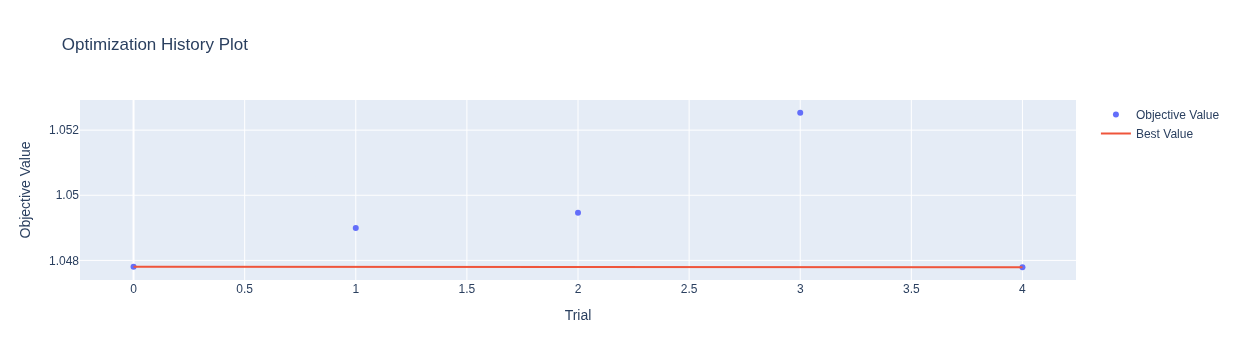

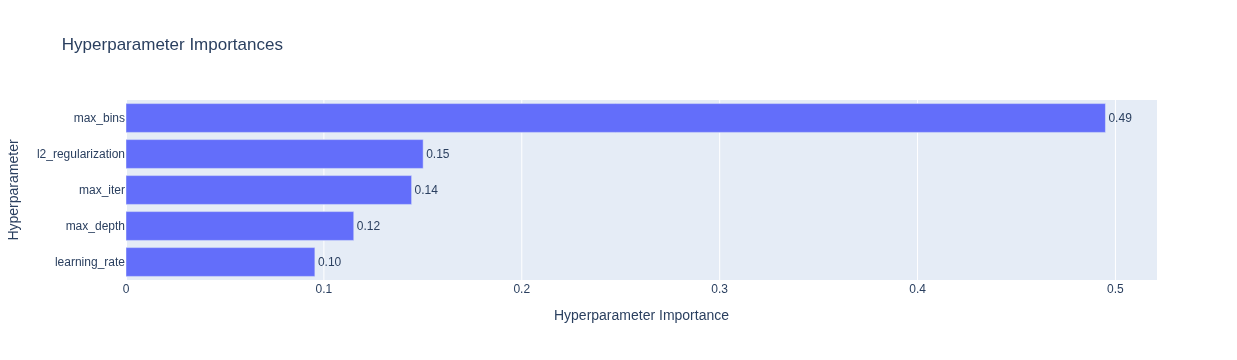

== xgb ==


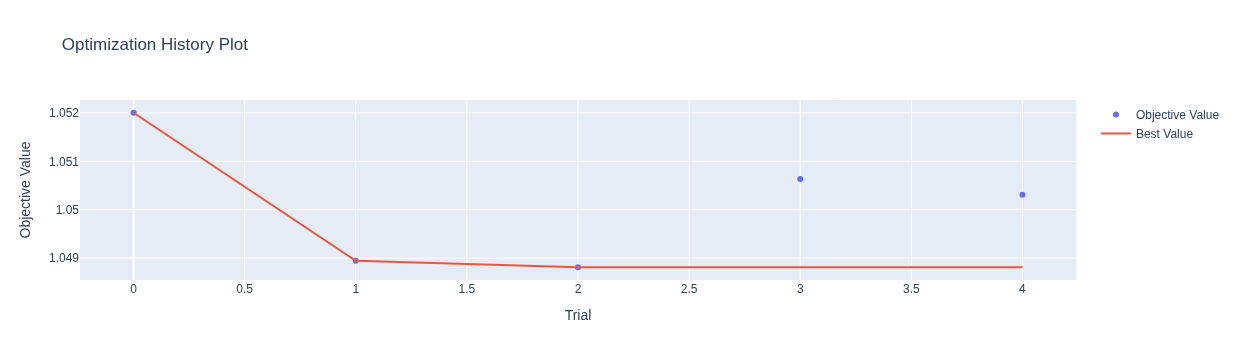

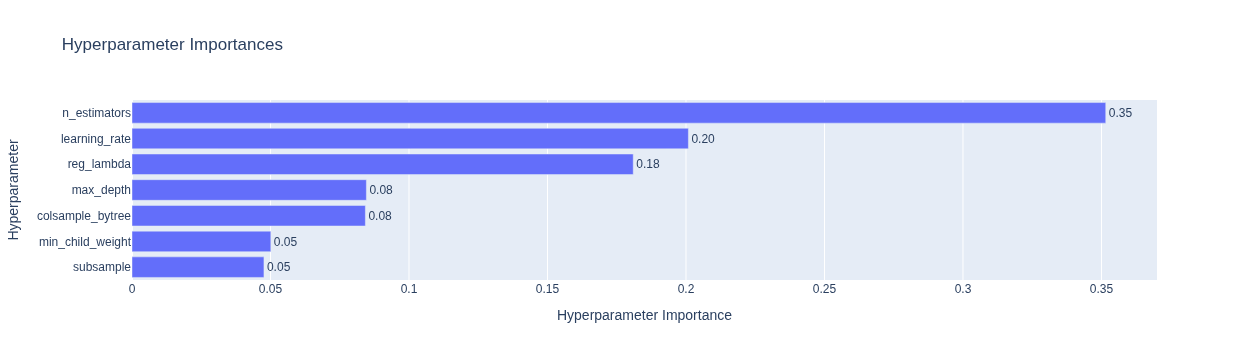

== lgbm ==


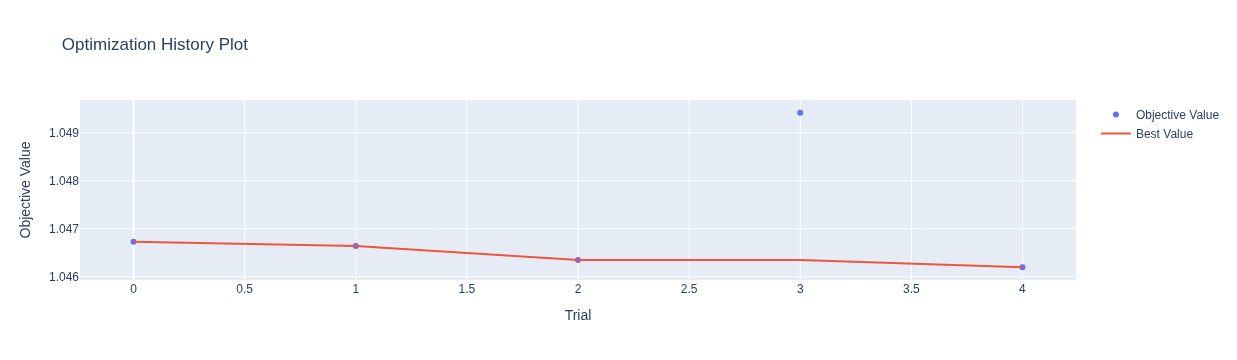

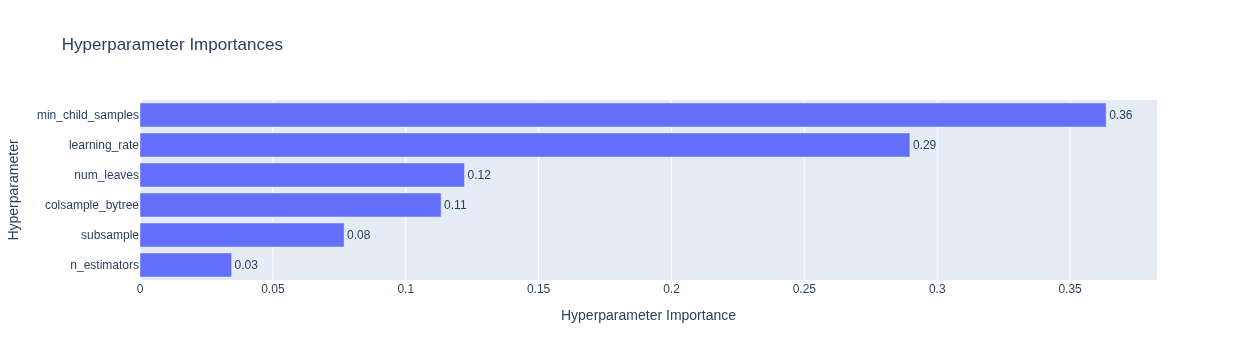

In [4]:
from optuna.visualization import plot_optimization_history, plot_param_importances

for k, st in studies.items():
    print(f"== {k} ==")
    display(plot_optimization_history(st))   # línea de convergencia esperada
    display(plot_param_importances(st))      # ranking de hiperparámetros